# 영화 추천 시스템 - 콘텐츠 기반 필터링(Content-based Filtering)
- Kaggle에 제공된 `TMDB 5000 Movie Dataset` 사용
- Count Vectorizer를 사용해 `장르` 속성을 기반으로 각 아이템 간의 콘텐츠에 대해 `유사도`를 계산하고, 이를 기반으로 추천

## 데이터 읽기

In [6]:
# 데이터 읽기
# kaggle 데이터: TMDB 5000 Movie Dataset
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('./tmdb_5000_movies.csv')
print(movies.shape)
movies.head()

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [9]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

## 데이터 전처리

In [8]:
# 데이터 선택
movies_df = movies[['id','title','genres','vote_average','vote_count','popularity','keywords','overview']]
movies_df.head()
# id, 영화제목 title, 장르 genres, 평균평점 vote_average, 투표수 vote_count, 인기 popularity, 키워드 keywords, 영화 개요 overview

,id,title,genres,vote_average,vote_count,popularity,keywords,overview
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",7.2,11800,150.437577,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",6.9,4500,139.082615,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",6.3,4466,107.376788,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",7.6,9106,112.312950,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",Following the death of District Attorney Harve...
4,49529,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",6.1,2124,43.926995,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","John Carter is a war-weary, former military ca..."


In [11]:
# genres 및 keywords 컬럼 값 조회
print(movies_df['genres'][0]) # genres의 값들은 보기엔 dict이지만 문자형이다(csv로 읽어오면서 바뀐 것)
movies_df[['genres'][:1]].values # genres와 keywords는 컬럼안에 dict형으로 저장됨

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]


array([['[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'],
       ['[{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}]'],
       ['[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 80, "name": "Crime"}]'],
       ...,
       ['[{"id": 35, "name": "Comedy"}, {"id": 18, "name": "Drama"}, {"id": 10749, "name": "Romance"}, {"id": 10770, "name": "TV Movie"}]'],
       ['[]'],
       ['[{"id": 99, "name": "Documentary"}]']], dtype=object)

In [19]:
# 문자열로 된 데이터를 변형
# genres와 keywords의 내용을 list와 dict로 복구
from ast import literal_eval

movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)
movies_df.head(2)

,id,title,genres,vote_average,vote_count,popularity,keywords,overview
0,19995,Avatar,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",7.2,11800,150.437577,"[{'id': 1463, 'name': 'culture clash'}, {'id':...","In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",6.9,4500,139.082615,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...","Captain Barbossa, long believed to be dead, ha..."


In [20]:
# dict의 value 값을 특성으로 사용하도록 변경
# genres, keywords 각 컬럼의 name key에 대한 value만 가져옴
movies_df['genres'] = movies_df['genres'].apply(lambda x: [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: [y['name'] for y in x])
movies_df[['genres','keywords']][:2]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon..."
1,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ..."


In [21]:
# genres의 리스트 안에 들어있는 각 단어들을 하나의 문장(띄어쓰기로 구분된)으로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x: (' '.join(x)))
movies_df.head(3)

,id,title,genres,vote_average,vote_count,popularity,keywords,overview,genres_literal
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",7.2,11800,150.437577,"[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy Science Fiction
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,4500,139.082615,"[ocean, drug abuse, exotic island, east india ...","Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Action
2,206647,Spectre,"[Action, Adventure, Crime]",6.3,4466,107.376788,"[spy, based on novel, secret agent, sequel, mi...",A cryptic message from Bond’s past sends him o...,Action Adventure Crime


In [23]:
# 문자열로 변환된 genres를 CountVectorize 수행
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


## 코사인 유사도 측정
- 장르 속성을 기반으로 각 아이템 간의 콘텐츠에 대해 유사도를 계산하는데, 코사인 유사도 사용
- 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도(두 벡터가 가리키는 방향이 얼마나 유사한가)를 의미합
- -1 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단

In [27]:
# 문장의 유사도 측정을 하는 방법 중 하나인 코사인 유사도 측정을 수행
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


- 코사인 유사도를 이용해 잠재 행렬을 만들었다
- confusion_matrix와 비슷하게 해석할 수 있다

In [28]:
# genre_sim 객체에서 높은 값 순으로 정렬
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


## 추천하는/유사한 영화 찾기

In [29]:
# 추천하는/유사한 영화를 DataFrame으로 반환하는 함수
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)
    
    return df.iloc[similar_indexes]

In [30]:
# 영화 '대부'와 유사한 영화는?
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


- 유사한 영화들을 찾았다
- 근데 평균 평점이 0인 것도 있다

In [31]:
# 다시 데이터를 탐색
movies_df[['title','vote_average','vote_count']].sort_values('vote_average', ascending=False)[:10]

# vote_count를 보니 평점 1개, 2개만 받은 건데 10점 또는 높게 받아서 평균 평점이 높은 것들도 있다

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


## 영화 선정을 위한 가중치 선정
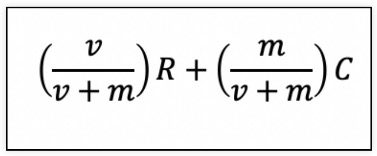
```
• v : 개별 영화에 평점을 투표한 횟수
• m : 평점을 부여하기 위한 최소 투표 횟수
• R : 개별 영화에 대한 평균 평점
• C : 전체 영화에 대한 평균 평점
```

In [32]:
# 영화 전체 평균평점과 최소 투표 횟수를 60%지점으로 지정
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:', round(C,3), 'm:', round(m,3))

C: 6.092 m: 370.2


In [34]:
# 가중치가 부여된 평점을 계산하기 위한 함수
def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']
    return ( (v/(v+m)) * R) + ( (m/(m+v)) * C)

In [35]:
# 다시 계산
movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1)
movies_df.head(3)

,id,title,genres,vote_average,vote_count,popularity,keywords,overview,genres_literal,weighted_vote
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",7.2,11800,150.437577,"[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy Science Fiction,7.166301
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,4500,139.082615,"[ocean, drug abuse, exotic island, east india ...","Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Action,6.838594
2,206647,Spectre,"[Action, Adventure, Crime]",6.3,4466,107.376788,"[spy, based on novel, secret agent, sequel, mi...",A cryptic message from Bond’s past sends him o...,Action Adventure Crime,6.284091


In [36]:
# 전체 데이터에서 가중치가 부여된 평점 순으로 정렬한 결과
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


## 추천하는/유사한 영화 찾기

In [37]:
# 유사한 영화를 찾는 함수를 변경
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
    
    similar_indexes = similar_indexes[similar_indexes != title_index]
    
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

In [38]:
# 다시 '대부'와 유사한 영화 찾기
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

# 이제 제대로 유사한 영화들이 찾아진 것 같다

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


---